**Using Meta's Llama LLM for generating summaries and Arize AI's Phoenix for analyzing article-summary pairs & evaluating with human-written reference summaries**.

Imagine you're responsible for your media company's summarization model that condenses daily news into concise summaries. Your model's performance has recently declined, leading to negative feedback from readers around the globe.

Phoenix helps you find the root-cause of LLM performance issues by analyzing prompt-response pairs.

In this tutorial, you will:

1.   Using curated LLM dataset
2.   Generate summary for the articles with Ollama
3.   Compute embeddings for each prompt (article) and response (ollama summary)
4.   Calculate different NLP scores to evaluate the quality of your LLM-generated
     summaries against human-written reference summaries
5.   Use Phoenix to find articles that your LLM is struggling to summarize

In [ ]:
!pip install ollama

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1


In [ ]:
!pip install colab-xterm
%load_ext colabxterm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 5.4 MB/s eta 0:00:00


In [ ]:
%xterm

Launching Xterm...

<IPython.core.display.Javascript object>

Once Xterm is launched it will show the terminal window /content, first we need to install ollama with the command: **curl https://ollama.ai/install.sh | sh**

Secondly, we need to start the ollama server with the command: **ollama serve &**

Finally, we need to pull the ollama model that we need with the command: **ollama pull llama3.2:latest** as we are using LLama3.2 version.

In [19]:
import pandas as pd
#import ollama
from tqdm import tqdm
from IPython.display import display

In [ ]:
def generate_ollama_summaries(df, model_name="llama3.2:latest", batch_size=10):
    # Create a copy
    df_copy = df.copy()

    # Initialize the new column
    df_copy['ollama_summary'] = None

    # Define the summarization prompt template
    def create_prompt(article):
        return f"Please summarize the following document in English:\n\n{article}"

    # Function to generate a single summary
    def generate_summary(article):
        try:
            response = ollama.generate(
                model=model_name,
                prompt=create_prompt(article)
            )
            return response.get('response', '')
        except Exception as e:
            print(f"Error generating summary: {str(e)}")
            return None

    # Process articles in batches with progress bar
    for i in tqdm(range(0, len(df_copy), batch_size), desc="Generating summaries"):
        batch = df_copy.iloc[i:i+batch_size]

        # Generate summaries for the batch
        for idx in batch.index:
            if pd.isna(df_copy.loc[idx, 'ollama_summary']):  # Only process if not already summarized
                article = df_copy.loc[idx, 'article']
                summary = generate_summary(article)
                df_copy.loc[idx, 'ollama_summary'] = summary

    return df_copy

def process_dataframe_with_ollama(input_df, model_name="llama3.2:latest", save_interval=50):
    # Generate summaries
    processed_df = generate_ollama_summaries(
        input_df,
        model_name=model_name,
        batch_size=save_interval
    )

    return processed_df

Note:- If you are running this code below switch to T4 GPU instance by changing the runtime type

In [ ]:
if __name__ == "__main__":

    df = pd.read_parquet(
        "./llm_summarization.parquet"
    )
    display(df.head(2))
    display(df.shape)
    processed_df = process_dataframe_with_ollama(df)
    display(processed_df.head(2))
    display(processed_df.shape)
    processed_df.to_parquet('./llm_summarization_ollama.parquet')

,prediction_timestamp,article,summary,reference_summary
0,2023-04-07 15:31:59.300109000,This is the moment when an angry woman forced ...,An elderly man was forced to kneel in the stre...,Man on moped knocked woman's phone out of her ...
1,2023-04-07 15:51:38.553976173,A Florida university is investigating the deat...,Bethune-Cookman University is investigating wh...,Bethune-Cookman University student Damian Park...


(1100, 4)

,prediction_timestamp,article,summary,reference_summary,ollama_summary
0,2023-04-07 15:31:59.300109000,This is the moment when an angry woman forced ...,An elderly man was forced to kneel in the stre...,Man on moped knocked woman's phone out of her ...,A shocking video from China shows an elderly m...
1,2023-04-07 15:51:38.553976173,A Florida university is investigating the deat...,Bethune-Cookman University is investigating wh...,Bethune-Cookman University student Damian Park...,Here is a summary of the document in English:\...


(1100, 5)

In [ ]:
# Using the processed output file
processed_df = pd.read_parquet(
        "./llm_summarization_ollama.parquet"
    )

In [ ]:
display(processed_df.head(2))
display(processed_df.shape)

,prediction_timestamp,article,summary,reference_summary,ollama_summary
0,2023-04-07 15:31:59.300109000,This is the moment when an angry woman forced ...,An elderly man was forced to kneel in the stre...,Man on moped knocked woman's phone out of her ...,A shocking video from China shows an elderly m...
1,2023-04-07 15:51:38.553976173,A Florida university is investigating the deat...,Bethune-Cookman University is investigating wh...,Bethune-Cookman University student Damian Park...,Here is a summary of the document in English:\...


(1100, 5)

In [ ]:
# Install Dependencies and Import Libraries
'''
Install Phoenix and the Arize SDK, which provides convenience methods for extracting embeddings and computing LLM evaluation metrics.
'''

In [ ]:
%pip install -Uq "arize-phoenix[embeddings]" "arize[AutoEmbeddings, LLM_Evaluation]" "arize-phoenix-otel"

In [ ]:
from arize.pandas.embeddings import EmbeddingGenerator, UseCases
from arize.pandas.generative.llm_evaluation import *
import phoenix as px
import os
from phoenix.otel import register

In [ ]:
# Add Phoenix API Key for tracing
PHOENIX_API_KEY = "Paste your API Key Here"
os.environ["PHOENIX_CLIENT_HEADERS"] = f"api_key={PHOENIX_API_KEY}"

# configure the Phoenix tracer
tracer_provider = register(
  project_name="LLM_SUMMARISATION_EMBEDDING_ANALYSIS",
  endpoint="https://app.phoenix.arize.com/v1/traces",
)

🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: LLM_SUMMARISATION_EMBEDDING_ANALYSIS
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: https://app.phoenix.arize.com/v1/traces
|  Transport: HTTP
|  Transport Headers: {'api_key': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



In [ ]:
baseline_df = processed_df[:300]
recent_df = processed_df[300:]
baseline_df = baseline_df.reset_index(
    drop=True
)  # recommended when using EmbeddingGenerator.generate_embeddings
recent_df = recent_df.reset_index(
    drop=True
)  # recommended when using EmbeddingGenerator.generate_embeddings
baseline_df.head()

,prediction_timestamp,article,summary,reference_summary,ollama_summary
0,2023-04-07 15:31:59.300109000,This is the moment when an angry woman forced ...,An elderly man was forced to kneel in the stre...,Man on moped knocked woman's phone out of her ...,A shocking video from China shows an elderly m...
1,2023-04-07 15:51:38.553976173,A Florida university is investigating the deat...,Bethune-Cookman University is investigating wh...,Bethune-Cookman University student Damian Park...,Here is a summary of the document in English:\...
2,2023-04-07 16:11:17.807843347,"It was once the edgiest place in town, attract...","The Variety Theater in Cleveland, once a buzzi...",Cleveland's Variety Theater was a renowned roc...,Here's a summary of the article in English:\n\...
3,2023-04-07 16:30:57.061710521,Unite baron Len McCluskey has boasted that tra...,"Len McCluskey, Unite's General Secretary, has ...",Unite boss Len McCluskey told members that Uni...,The article discusses the significant influenc...
4,2023-04-07 16:50:36.315577695,Amazon is trialling a scheme that could spell...,Amazon is launching a pilot scheme in Munich i...,Pilot begins in May for Prime customers who d...,Amazon is launching a pilot scheme that allows...


In [ ]:
# Compute LLM Evaluation Metrics
# Compute ROUGE-L scores to compare the OLLAMA LLM-generated summary with the human-written reference summary.
## A high ROUGE-L score mean that the LLM's summary closely matches the human reference summary.

In [ ]:
def compute_rougeL_scores(df: pd.DataFrame) -> pd.Series:
    return rouge(
        response_col=df["ollama_summary"],
        references_col=df["reference_summary"],
        rouge_types=["rougeL"],
    )["rougeL"]


baseline_df["rougeL_score"] = compute_rougeL_scores(baseline_df)
recent_df["rougeL_score"] = compute_rougeL_scores(recent_df)

  arize.utils.logging | INFO | Loading metric: rouge


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


  arize.utils.logging | INFO | Computing rouge scores


  0%|          | 0/300 [00:00<?, ?it/s]

  arize.utils.logging | INFO | Loading metric: rouge
  arize.utils.logging | INFO | Computing rouge scores


  0%|          | 0/800 [00:00<?, ?it/s]

In [20]:
display(recent_df.head(2))

,prediction_timestamp,article,summary,reference_summary,ollama_summary,rougeL_score,Glue_score,meteor_score,article_vector,summary_vector
0,2023-04-11 17:48:15.460261138,Opera isn't normally a field associated with a...,"Chinese opera singer, Liu Guijuan, has been cr...",Liu Guijuan shared pictures of the headdress o...,A Chinese opera singer named Liu Guijuan has f...,0.104869,0.036403,0.246269,"[-0.13748018443584442, -0.2512560486793518, -0...","[-0.07509738206863403, -0.17454302310943604, -..."
1,2023-04-11 18:07:54.714128312,A teenage driver who held her license for one ...,A 17-year-old driver who held her license for ...,Five people were hospitalised following a cras...,Here's a summary of the document in English:\n...,0.262626,0.152747,0.459855,"[-0.3334905207157135, -0.2956925332546234, -0....","[-0.4244343936443329, -0.1892535388469696, -0...."


In [ ]:
# Compute LLM Evaluation Metrics
# Compute GLUE scores to compare the OLLAMA LLM-generated summary with the human-written reference summary.
## A high Google-Bleu score mean that the LLM's summary closely matches the human reference summary.

In [ ]:
def compute_glue_scores(df: pd.DataFrame) -> pd.Series:
    return google_bleu(
        response_col=df["ollama_summary"],
        references_col=df["reference_summary"]
          )


baseline_df["Glue_score"] = compute_glue_scores(baseline_df)
recent_df["Glue_score"] = compute_glue_scores(recent_df)

  arize.utils.logging | INFO | Loading metric: google_bleu
  arize.utils.logging | INFO | Computing google_bleu scores


  0%|          | 0/300 [00:00<?, ?it/s]

  arize.utils.logging | INFO | Loading metric: google_bleu
  arize.utils.logging | INFO | Computing google_bleu scores


  0%|          | 0/800 [00:00<?, ?it/s]

In [ ]:
# Compute LLM Evaluation Metrics
# Compute meteor scores to compare the OLLAMA LLM-generated summary with the human-written reference summary.
## A high meteor score mean that the LLM's summary closely matches the human reference summary.

In [ ]:
def compute_meteor_scores(df: pd.DataFrame) -> pd.Series:
    return meteor(
        response_col=df["ollama_summary"],
        references_col=df["reference_summary"]
    )


baseline_df["meteor_score"] = compute_meteor_scores(baseline_df)
recent_df["meteor_score"] = compute_meteor_scores(recent_df)

  arize.utils.logging | INFO | Loading metric: meteor


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


  arize.utils.logging | INFO | Computing meteor scores


  0%|          | 0/300 [00:00<?, ?it/s]

  arize.utils.logging | INFO | Loading metric: meteor
  arize.utils.logging | INFO | Computing meteor scores


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


  0%|          | 0/800 [00:00<?, ?it/s]

In [ ]:
print(baseline_df.head(2))

           prediction_timestamp  \
0 2023-04-07 15:31:59.300109000   
1 2023-04-07 15:51:38.553976173   

                                             article  \
0  This is the moment when an angry woman forced ...   
1  A Florida university is investigating the deat...   

                                             summary  \
0  An elderly man was forced to kneel in the stre...   
1  Bethune-Cookman University is investigating wh...   

                                   reference_summary  \
0  Man on moped knocked woman's phone out of her ...   
1  Bethune-Cookman University student Damian Park...   

                                      ollama_summary  rougeL_score  \
0  A shocking video from China shows an elderly m...      0.146853   
1  Here is a summary of the document in English:\...      0.237975   

   Glue_score  meteor_score  
0    0.054672      0.328099  
1    0.160033      0.549575  


In [ ]:
'''
Compute Embeddings for Prompts and Responses - i.e., e embeddings for articles and ollama summaries.
'''

In [ ]:
generator = EmbeddingGenerator.from_use_case(
    use_case=UseCases.NLP.SUMMARIZATION,
    model_name="distilbert-base-uncased",
)
baseline_df["article_vector"] = generator.generate_embeddings(text_col=baseline_df["article"])
baseline_df["summary_vector"] = generator.generate_embeddings(text_col=baseline_df["ollama_summary"])
recent_df["article_vector"] = generator.generate_embeddings(text_col=recent_df["article"])
recent_df["summary_vector"] = generator.generate_embeddings(text_col=recent_df["ollama_summary"])

  arize.utils.logging | INFO | Downloading pre-trained model 'distilbert-base-uncased'


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

  arize.utils.logging | INFO | Downloading tokenizer for 'distilbert-base-uncased'


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

  arize.utils.logging | INFO | Generating embedding vectors


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

  arize.utils.logging | INFO | Generating embedding vectors


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

  arize.utils.logging | INFO | Generating embedding vectors


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

  arize.utils.logging | INFO | Generating embedding vectors


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [ ]:
'''
Launch Phoenix
Define a schema to tell Phoenix what the columns of your dataframe represent (tags, prompts, responses, etc.).
See the docs for guides on how to define your own schema and API reference on phoenix.Schema and phoenix.EmbeddingColumnNames.
'''

In [ ]:
schema = px.Schema(
    timestamp_column_name="prediction_timestamp",
    tag_column_names=[
        "rougeL_score",
        "Glue_score",
        "meteor_score",
        "reference_summary",
    ],
    prompt_column_names=px.EmbeddingColumnNames(
        vector_column_name="article_vector", raw_data_column_name="article"
    ),
    response_column_names=px.EmbeddingColumnNames(
        vector_column_name="summary_vector", raw_data_column_name="ollama_summary"
    ),
)

In [ ]:
### Create Phoenix datasets that wrap your dataframes with schemas that describe them.

In [ ]:
baseline_ds = px.Inferences(dataframe=baseline_df, schema=schema, name="baseline")
recent_ds = px.Inferences(dataframe=recent_df, schema=schema, name="recent")

In [ ]:
### Launch Phoenix. Follow the instructions in the cell output to open the Phoenix UI in the notebook or in a new browser tab.

In [ ]:
(session := px.launch_app(primary=recent_ds, reference=baseline_ds)).view()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


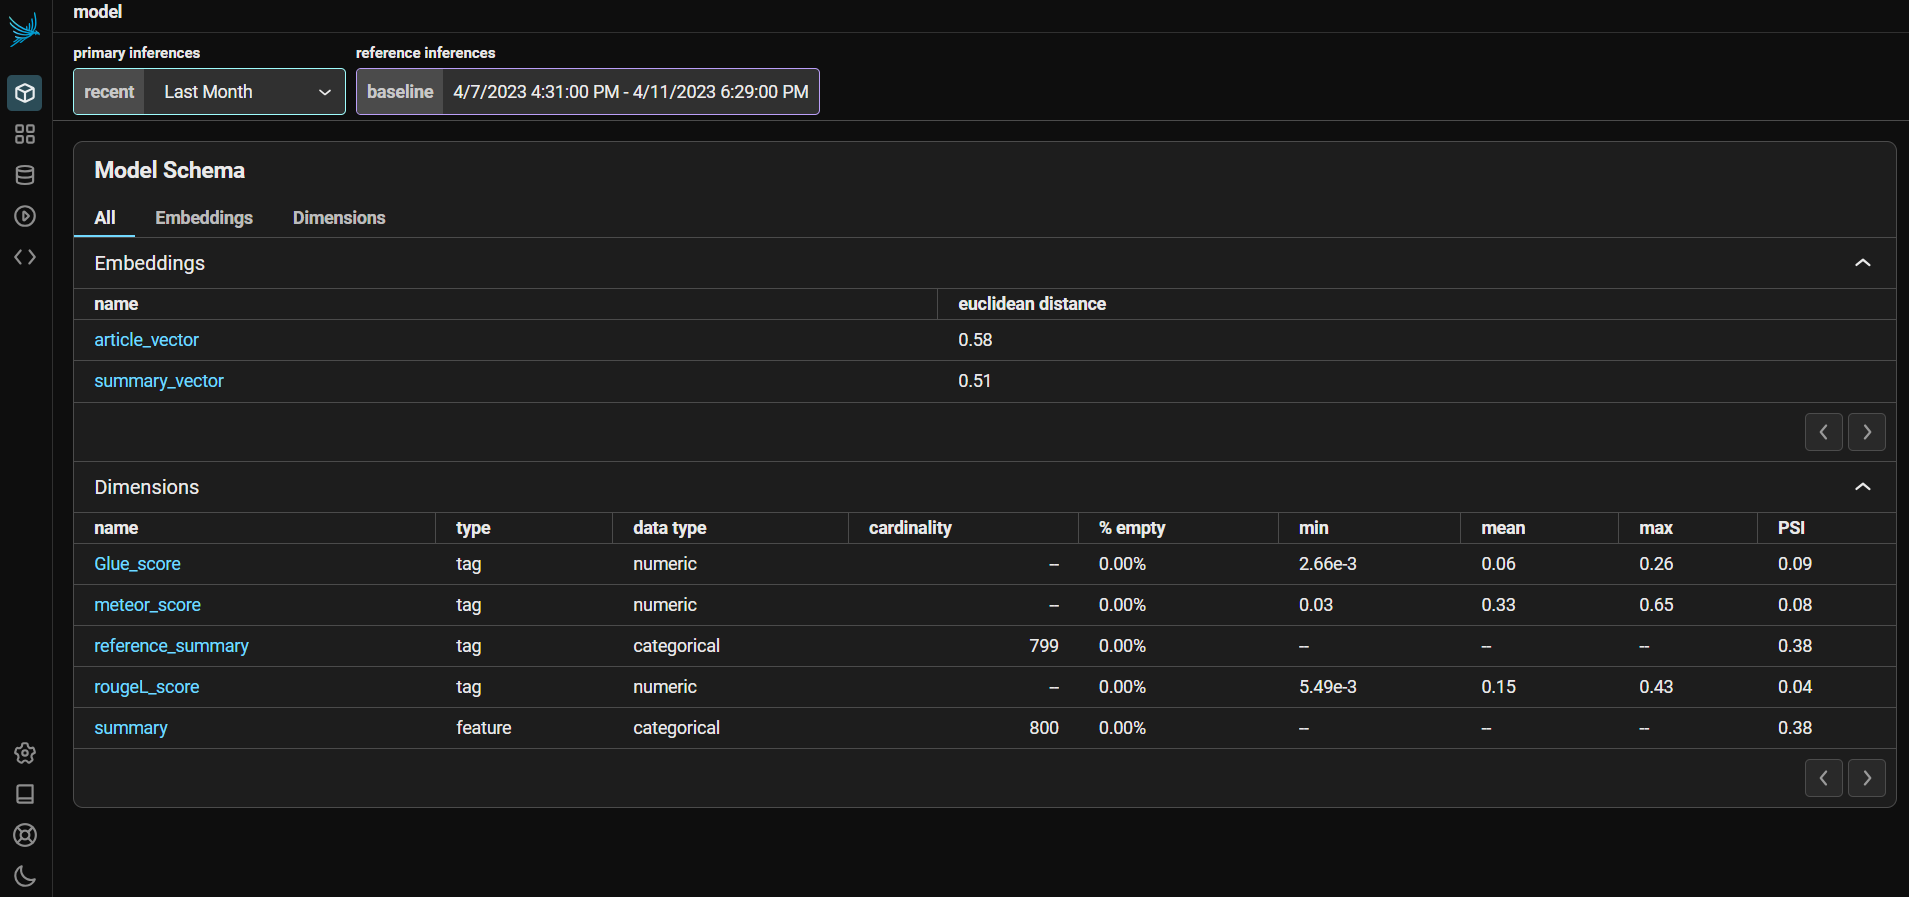

Find the Root-Cause of Your Model Performance Issue
Use Phoenix to find the root-cause of your LLM's performance issue.

Click on "article_vector" to go to the embeddings view for your prompts (the input news articles).

Select a period of high drift

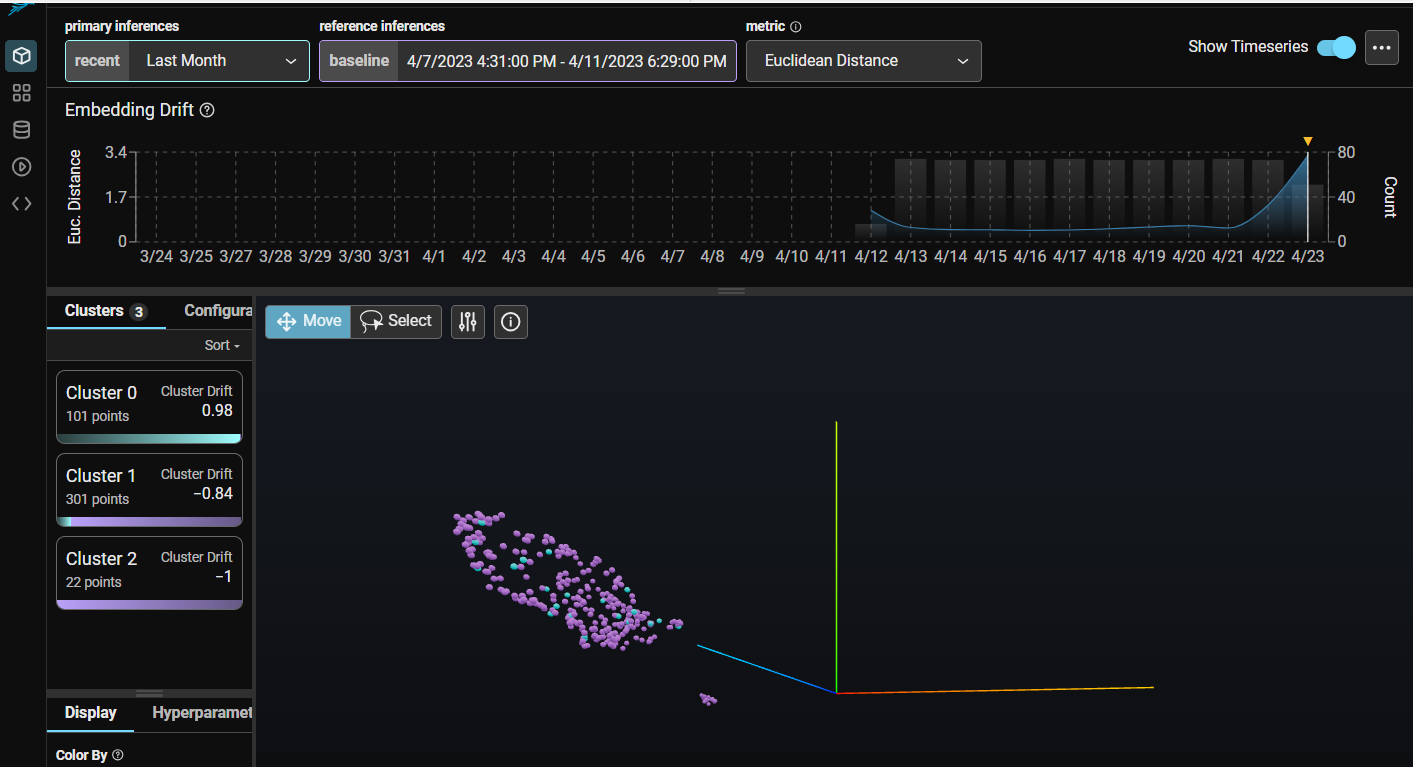)

Color your data by the "rougeL_score" dimension. The problematic clusters have low ROUGE-L score in blue, the well-performing clusters have high ROUGE-L score in green.

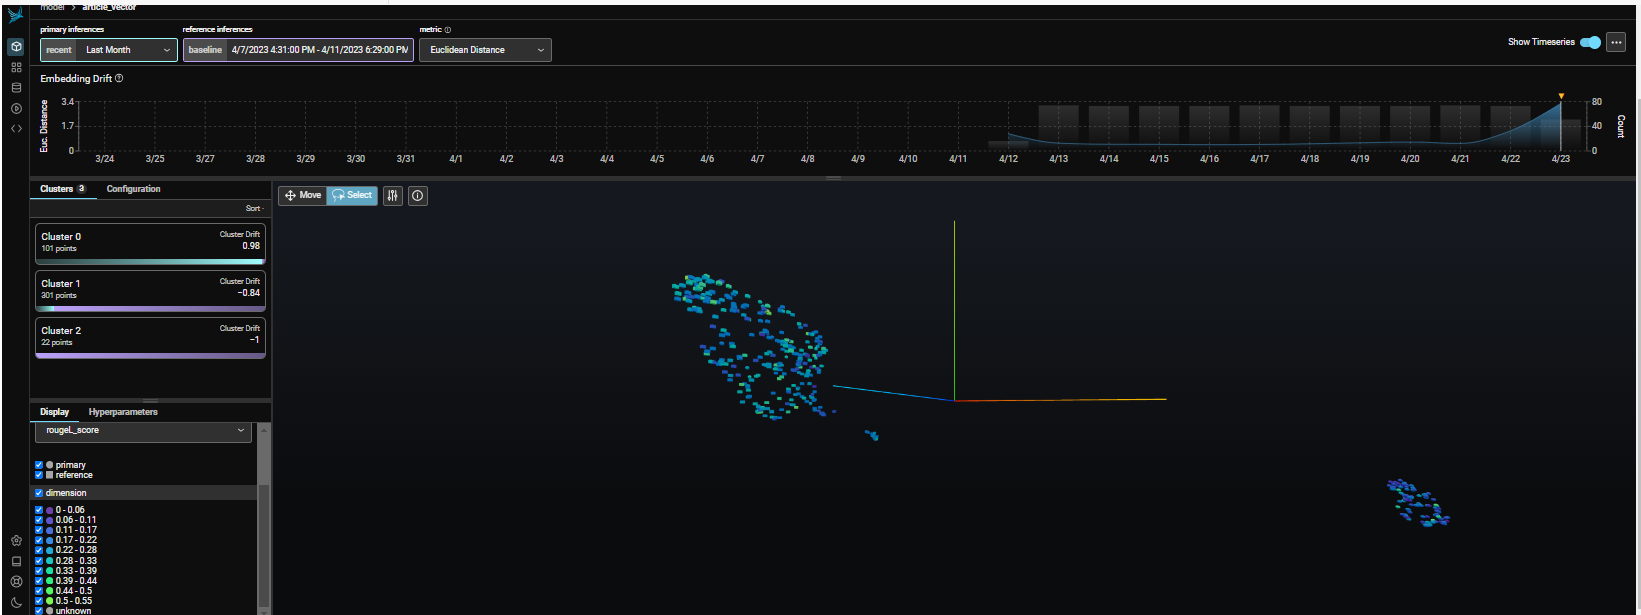)

Use the lasso to select part of your data and inspect the prompt-response pairs.

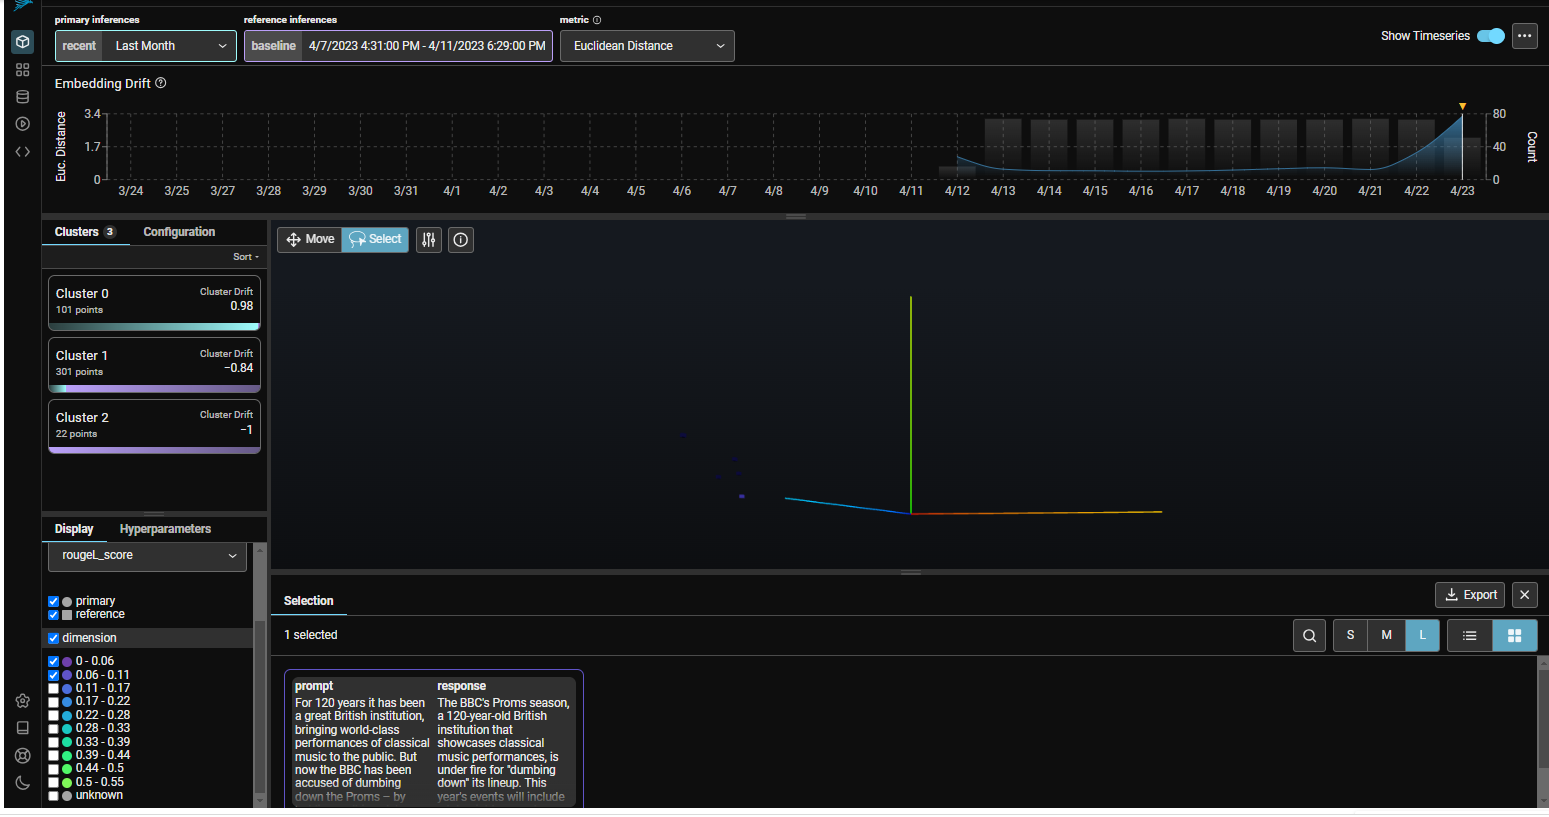

Select each clusters in the left panel and look at the prompt-response pairs. Notice that the LLM is doing a good job summarizing the English articles in the green cluster (high ROUGE-L score), but is struggling to summarize Dutch articles in the blue cluster (low ROUGE-L score).

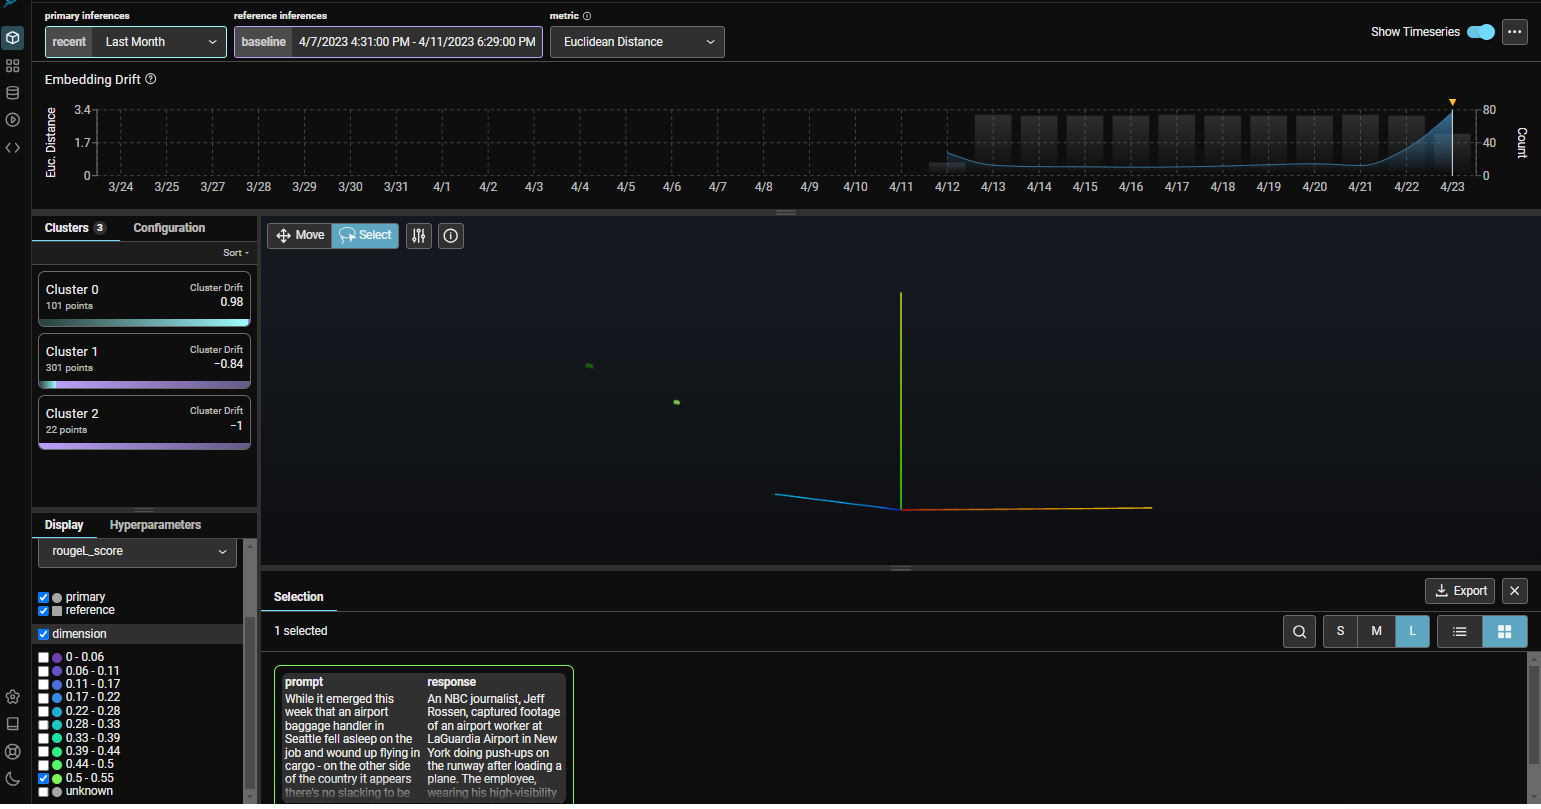

Inspecting a particular instance of English article

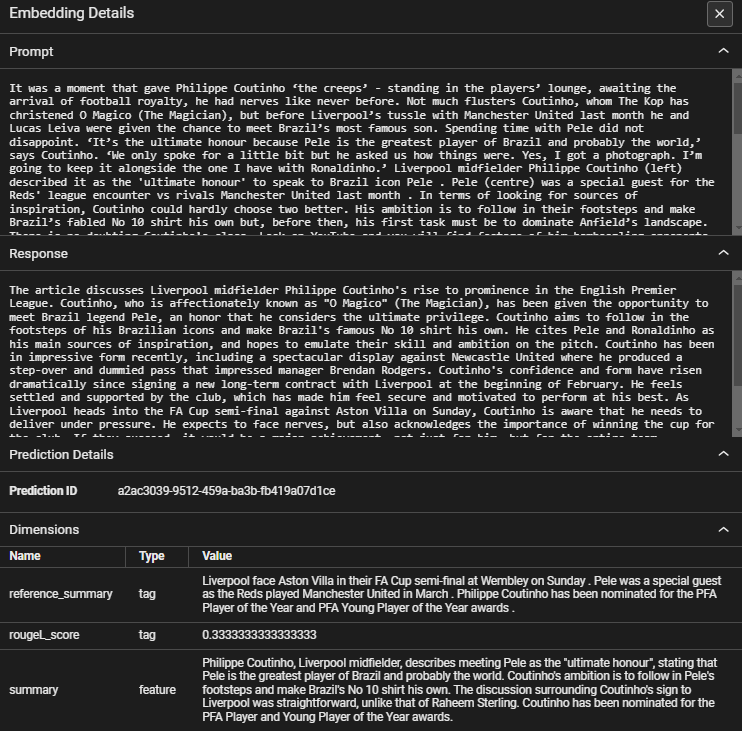

Inspecting a particular instance of Dutch article where you can notice that the LLM struggles to summarise it well with a lower ROUGE-L score

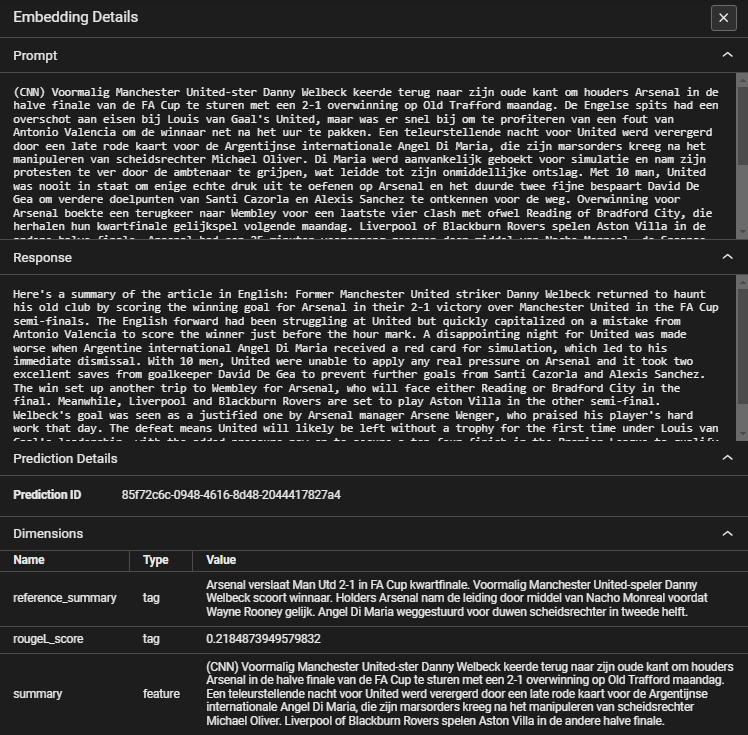